In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

from tqdm import tqdm

In [3]:
np.random.seed(0)
torch.manual_seed(0) 
sns.set_style('darkgrid')

In [4]:
root_dir = "../data/CNN_images/Run1/" 

In [5]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [6]:
natural_img_dataset = datasets.ImageFolder(
    root = root_dir,
    transform = image_transforms["train"]
)  

In [14]:
idx2class = {v: k for k, v in natural_img_dataset.class_to_idx.items()}
print(idx2class)

{0: 'J2', 1: 'J2_Def', 2: 'Q102', 3: 'Q102_Def', 4: 'U100', 5: 'U100_Def', 6: 'U500', 7: 'U600', 8: 'U600_Def', 9: 'U608', 10: 'U701', 11: 'U701_Def', 12: 'U901AL', 13: 'U904U3', 14: 'U904U3_Def', 15: 'U911U5', 16: 'U911U5_Def'}


Text(0.5, 1.0, 'Images Class Distribution')

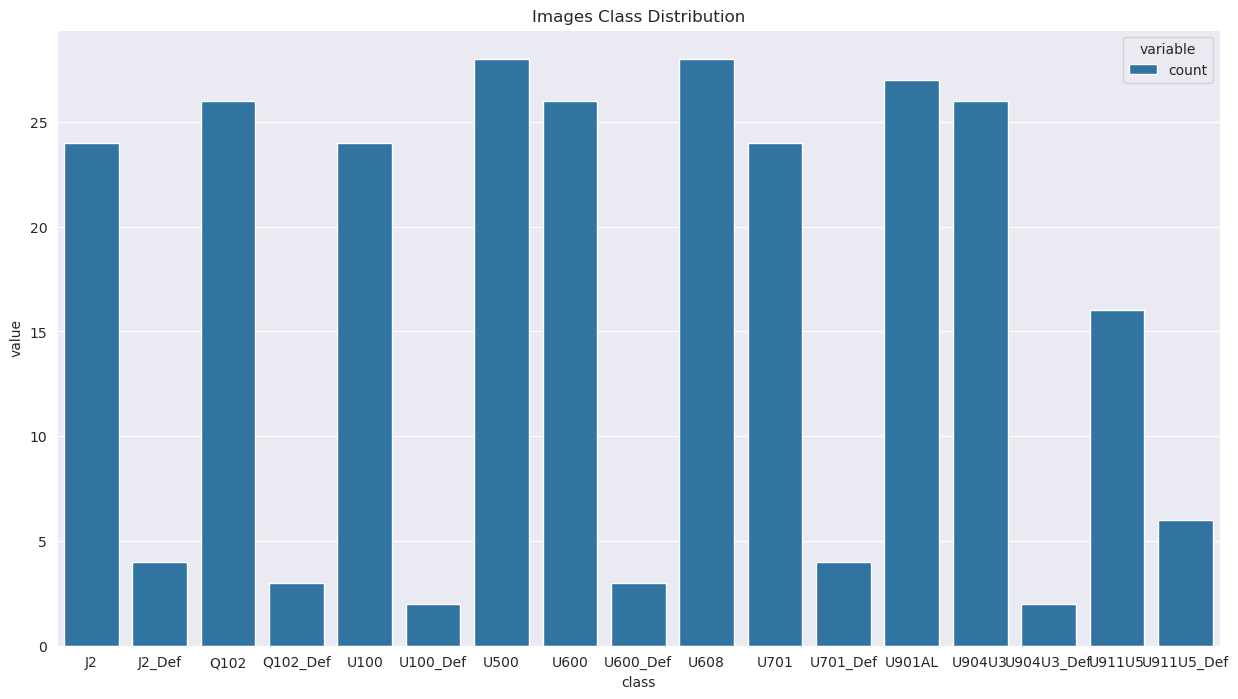

In [8]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
# print("Distribution of classes: \n", get_class_distribution(natural_img_dataset))  

plt.figure(figsize=(15,8))
sns.barplot(data=pd.DataFrame.from_dict(get_class_distribution(natural_img_dataset), orient='index').reset_index().
            rename(columns={'index':'class', 0:'count'}).melt(id_vars=['class'], var_name='variable', 
            value_name='value'), x='class', y='value', hue='variable').set_title('Images Class Distribution')

In [13]:
# WeightedRandomSampler

# WeightedRandomSampler is used, unlike random_split and SubsetRandomSampler, to ensure that each batch sees a proportional number of all classes.

#     Get all the target classes.
#     Get the class weights. Class weights are the reciprocal of the number of items per class.
#     Obtain corresponding weight for each target sample.

target_list = torch.tensor(natural_img_dataset.targets)
class_count = [i for i in get_class_distribution(natural_img_dataset).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

print(class_weights)
class_weights_all = class_weights[target_list]
print(class_weights_all)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(natural_img_dataset))
val_size = len(natural_img_dataset) - train_size
train_dataset, val_dataset = random_split(natural_img_dataset, [train_size, val_size])

# Create a weighted sampler for the train dataset
train_target_list = torch.tensor(train_dataset.dataset.targets)
train_class_weights_all = class_weights[train_target_list]
train_weighted_sampler = WeightedRandomSampler(
    weights=train_class_weights_all,
    num_samples=len(train_class_weights_all),
    replacement=True
)

# Create a sampler for the validation dataset
val_sampler = SubsetRandomSampler(val_dataset.indices)

# Create data loaders for train and validation datasets
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=8, sampler=train_weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=8, sampler=val_sampler)


tensor([0.0417, 0.2500, 0.0385, 0.3333, 0.0417, 0.5000, 0.0357, 0.0385, 0.3333,
        0.0357, 0.0417, 0.2500, 0.0370, 0.0385, 0.5000, 0.0625, 0.1667])
tensor([0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417,
        0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417,
        0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.2500, 0.2500, 0.2500,
        0.2500, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385,
        0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385,
        0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385, 0.0385,
        0.3333, 0.3333, 0.3333, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417,
        0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417,
        0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417,
        0.5000, 0.5000, 0.0357, 0.0357, 0.0357, 0.0357, 0.0357, 0.0357, 0.0357,
        0.0357, 0.0357, 0.0357, 0.0357, 0.0357,